# Video encoding & classification using TensorFlow 2.0

**Abstract**: in this workshop, you will learn how to implement deep neural networks using keras & tensorflow 2.0 to optimally encode and classify videos. It will be a hands-on tuto on a video dataset (UCF-101 dataset)

### Summary of the hack session

- 1. **Dataset extraction (UCF-101 dataset)** (5')
- 2. **Frames features extraction** (5-10')
    - 2.a. RGB features 
    - 2.b. Transfer learning of pretrained CNN models 
- 3. **Unsupervised learning** (20')
    - 3.a. Average pooling  
    - 3.b. LSTM autoencoders
- 4. **Supervised learning: video classification** (10')
    - 4.a. Average pooling  
    - 4.b. RNN : LSTM 
- 5. **Introduction to multi-modal classification models** (5')
    - 5.a. Definition
    - 5.b. Modes aggregation/combination

# 1. Dataset extraction

### UCF-101 dataset presentation

The UCF-101 dataset is standard open source dataset containing: 

- **13320 short videos** (several seconds on average) in avi format
- classified in **101 classes** (human actions like "Mixing", ...)
- already split into train and test sets

--> more details can be found here: **https://www.crcv.ucf.edu/data/UCF101.php**

### Requirements

- **Downloads**: 
    - videos are already downloaded in the folder: **"videos/"** (7.2 Go)
    - train/test split information can be found in the folder: "ucfTrainTestlist/"

- **Setup**:
    - **tensorflow==2.0**
    - keras==2.3.1
    - cv2==4.1.1

### Imports

In [1]:
# general import
import os
import math   
from tqdm import tqdm
import matplotlib.pyplot as plt    
%matplotlib inline
from IPython.display import Image
import numpy as np    
import pandas as pd

# ML import
from sklearn.preprocessing import LabelBinarizer

# images import
import cv2     # opencv, need to be installed with pip install opencv-python
from keras.preprocessing import image   

Using TensorFlow backend.


### Extracting and saving the frames for train and test set 

In this section, we will **extract the frames (jpg format)** of the videos and **save** them for later use.

In [2]:
def get_video_names(task):
    
    """
    This function returns the video filepaths 
    for the given set ("train" or "test")
    """
    
    f = open("ucfTrainTestlist/"+task+"list01.txt", "r")
    temp = f.read()
    videos = temp.split('\n')[:-1]
    videos = ["videos/"+video.split(' ')[0].split('/')[1] for video in videos]
    
    return videos

In [3]:
def extract_frames(task, videos):
    
    """
    This function will extract & save the frames for 
    a given list of video filepaths 
    """
    
    # creating the repo 
    try:
        os.mkdir(task)
    except:
        pass
    
    # extracting the frames from the videos
    frames = []
    targets = []

    for video in tqdm(videos):
        video_frames = []
        count = 0
        cap = cv2.VideoCapture(video)   # capturing the video from the given path
        frameRate = cap.get(5) #frame rate
        x=1
        while(cap.isOpened()):
            frameId = cap.get(1) # current frame number
            ret, frame = cap.read()
            if (ret != True):
                break
            if (frameId % math.floor(frameRate) == 0):
                # storing the frames in the task folder 
                filename = task + '/' + video.split("/")[-1] +"_frame%d.jpg" % count;count+=1
                cv2.imwrite(filename, frame)
                video_frames.append(filename)

        frames.append(video_frames)
        targets.append(video.split("_")[-3])

        cap.release()

    # now saving information into a file
    data = pd.DataFrame()
    data['videos'] = videos
    data["frames"] = frames
    data["targets"] = targets
    
    return data

**we run the frames extraction for train and test sets**: JPG images will be saved in *train* and *test* folders.

**[DO NOT RUN]**

In [5]:
for task in ["train", "test"]:
    
    print(task)
    
    videos = get_video_names(task)
    print(videos[:3])
    
    dataset = extract_frames(task, videos)
    dataset.to_json(task+'.json')


  0%|          | 3/9537 [00:00<06:37, 23.96it/s]

train
['videos/v_ApplyEyeMakeup_g08_c01.avi', 'videos/v_ApplyEyeMakeup_g08_c02.avi', 'videos/v_ApplyEyeMakeup_g08_c03.avi']



100%|██████████| 9537/9537 [11:19<00:00, 14.03it/s]

  0%|          | 0/3783 [00:00<?, ?it/s]

test
['videos/v_ApplyEyeMakeup_g01_c01.avi', 'videos/v_ApplyEyeMakeup_g01_c02.avi', 'videos/v_ApplyEyeMakeup_g01_c03.avi']



 80%|███████▉  | 3020/3783 [03:52<00:55, 13.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# 2. Frames feature extraction 

The purpose of this section is to **extract relevant features for each frame** of a video. 

For each video, we first load the JPG images extracted in the previous section and then we **compute features for each frame using a pretrained convolutional neural network** (eg : Inception-v3, VGG16, ...) . 

We will also **binarize** our target (101 classes).

#### Load the dataset information

In [4]:
train = pd.read_json("train.json")

In [7]:
train.targets.value_counts()

Punch            121
PlayingCello     120
CricketShot      118
ShavingBeard     118
PlayingGuitar    117
                ... 
PullUps           72
PushUps           72
Skijet            72
TaiChi            72
PlayingViolin     72
Name: targets, Length: 101, dtype: int64

In [8]:
train.frames.apply(len).describe()

count    9537.000000
mean        7.742896
std         3.736407
min         2.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        72.000000
Name: frames, dtype: float64

In [9]:
train.frames.apply(len).sum()

73844

In [10]:
train.head()

,frames,targets,videos
0,[train/v_ApplyEyeMakeup_g08_c01.avi_frame0.jpg...,ApplyEyeMakeup,videos/v_ApplyEyeMakeup_g08_c01.avi
1,[train/v_ApplyEyeMakeup_g08_c02.avi_frame0.jpg...,ApplyEyeMakeup,videos/v_ApplyEyeMakeup_g08_c02.avi
10,[train/v_ApplyEyeMakeup_g09_c06.avi_frame0.jpg...,ApplyEyeMakeup,videos/v_ApplyEyeMakeup_g09_c06.avi
100,[train/v_ApplyEyeMakeup_g25_c07.avi_frame0.jpg...,ApplyEyeMakeup,videos/v_ApplyEyeMakeup_g25_c07.avi
1000,"[train/v_Biking_g10_c06.avi_frame0.jpg, train/...",Biking,videos/v_Biking_g10_c06.avi


## 2.a. RGB features 

We will extract the **RGB** features for each frames of a video. Each frame is a 3D-tensor of size (n_pixels, n_pixels, 3). So each pixel is encoded with 3 features : **Red**, **Green** and **Blue** colors. 

In [5]:
def load_images(files):
    
    """
    This function loads RGB features of a given image
    """
    
    images = []
    
    for f in files:

        img = image.load_img(f, target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img/255
        
        images.append(img)
        
    return np.array(images)

In [12]:
files = train.frames.iloc[10]
len(files)

6

In [13]:
rgb = load_images(files)
rgb[0].shape

(224, 224, 3)

In [14]:
rgb[0][100, 100]

array([0.14901961, 0.14117648, 0.14509805], dtype=float32)

## 2.b. Transfer learning of pretrained CNN models

We will use **Inception-v3** convolutional neural network which was pretrained on ImageNet to compute relevant features (edges, shapes, ...) **for each frame**. There exists several other pretrained CNN models (VGG16, ...) which can be tested easily by adapting the following code. 

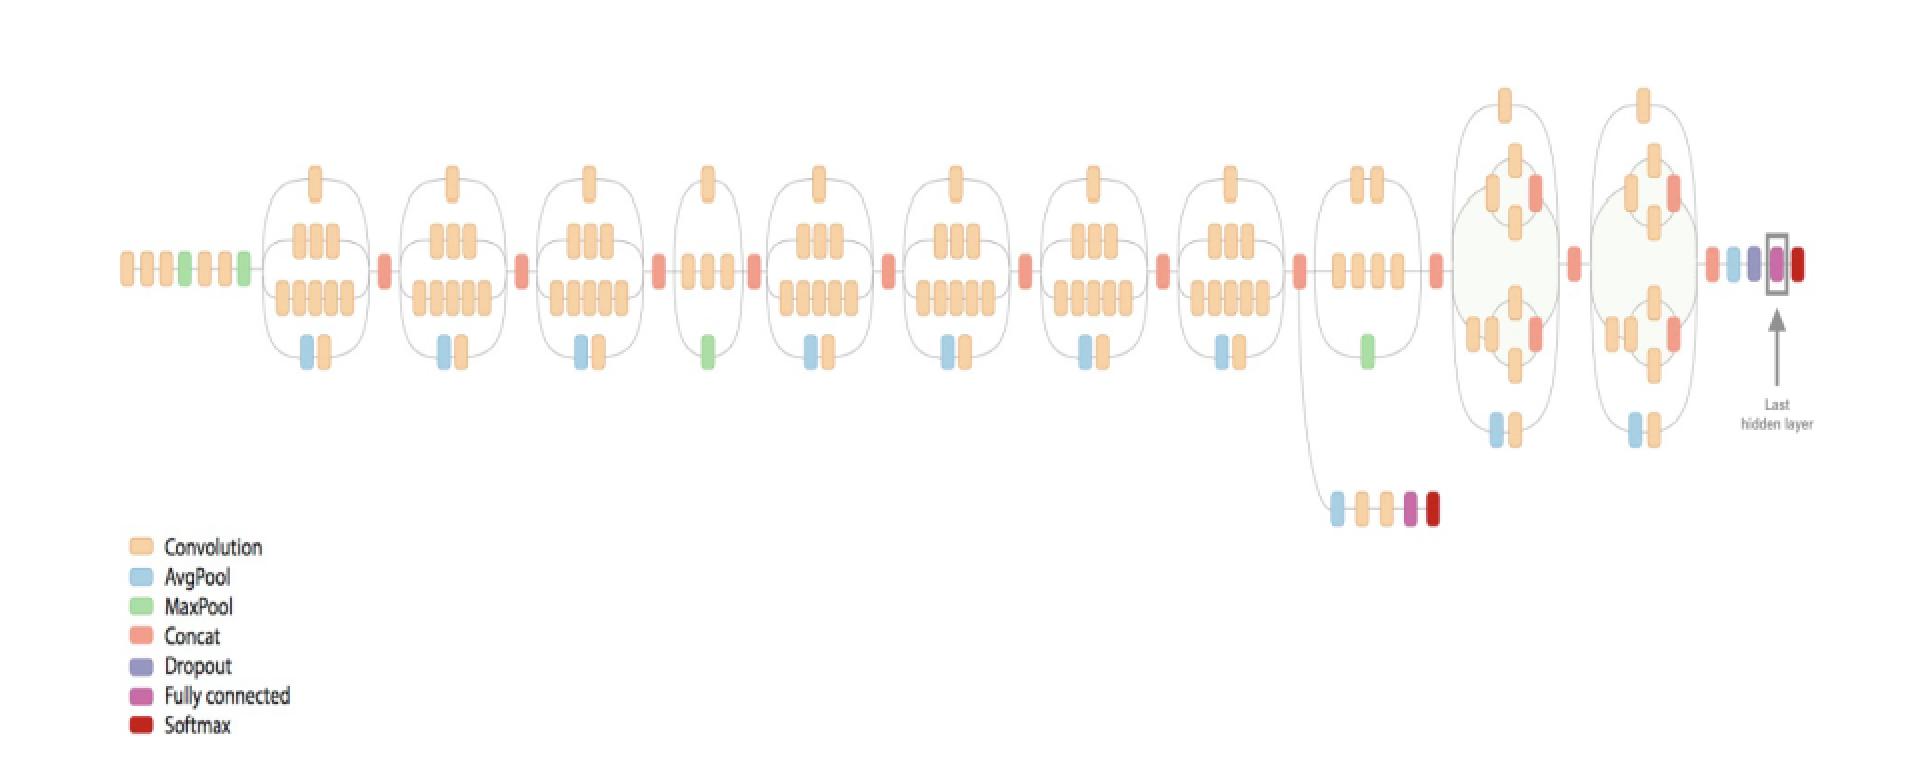

In [264]:
Image("pictures/inceptionv3.png")

we load Inception-V3 model...

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

feature_extractor = InceptionV3(weights='imagenet', include_top=False, pooling="avg")

we also prepare our target for later use...

In [7]:
binarizer = LabelBinarizer()
classes = train.targets.unique()
binarizer.fit(classes)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

**Now, we define a function that will:**

- **load** the images and extract **RGB features**
- compute **Inception-v3 average pooling representations** for each one 
- **binarize** the 101 labels

In [2]:
def compute_batch_record(batch_data, feature_extractor, binarizer):
    
    """
    This function runs the frames extraction (RGB) & frames feature 
    extraction and binarize the target for data batch.
    """
    
    n_videos = len(batch_data)
    
    # extract the frames for the video batch
    print("extracting the frames for {} videos...".format(n_videos))
    
    frames = np.concatenate([load_images(batch_data.frames.iloc[v]) 
                             for v in tqdm(range(n_videos))])
    
    # extract the features
    print("computing the features for {} videos...".format(n_videos))
    features = feature_extractor.predict(frames)
    
    # regroup per video
    embeddings = []
    
    index = 0 
    
    for v in range(n_videos):
        
        n_images = len(batch_data.frames.iloc[v])
                                
        embeddings.append(features[index : index+n_images])
        
        index += n_images
        
    # binarize the target
    labels = binarizer.transform(batch_data.targets).tolist()

    return (
        list(batch_data.videos), 
        embeddings, 
        list(batch_data.targets),
        labels
    )

**we run the frames features extraction for some samples :**

In [18]:
n_sample = 50
%time record = compute_batch_record(train.sample(n_sample), feature_extractor, binarizer)


 20%|██        | 10/50 [00:00<00:00, 92.95it/s]

extracting the frames for 50 videos...



100%|██████████| 50/50 [00:00<00:00, 81.16it/s]


computing the features for 50 videos...
CPU times: user 7.69 s, sys: 1.49 s, total: 9.18 s
Wall time: 10.4 s


**NOTE**: each image with initial shape (224, 224, 3) **will be now encoded into a 1D tensor of shape (2048, )** : 

In [4]:
record[1][0][0].shape

(2048,)


# 3. Unsupervised learning (or video feature extraction)

Videos can now be considered as multi-dimensional time series. The purpose of this section is to find a "relevant" **1D-tensor representation of the videos.**

## 3.a. Average pooling representation 

We just **average the features** of each frame to get the video representation

In [72]:
n_sample = 500
%time record = compute_batch_record(train.sample(n_sample), feature_extractor, binarizer)



  0%|          | 0/500 [00:00<?, ?it/s]

  1%|          | 3/500 [00:00<00:18, 26.24it/s]

extracting the frames for 500 videos...




  1%|▏         | 7/500 [00:00<00:17, 28.52it/s]

  2%|▏         | 9/500 [00:00<00:20, 23.99it/s]

  2%|▏         | 12/500 [00:00<00:19, 25.45it/s]

  3%|▎         | 16/500 [00:00<00:19, 24.65it/s]

  4%|▍         | 19/500 [00:00<00:20, 23.99it/s]

  4%|▍         | 22/500 [00:00<00:19, 24.40it/s]

  5%|▌         | 25/500 [00:00<00:18, 25.74it/s]

  6%|▌         | 28/500 [00:01<00:22, 20.81it/s]

  6%|▌         | 31/500 [00:01<00:28, 16.47it/s]

  7%|▋         | 33/500 [00:01<00:28, 16.31it/s]

  7%|▋         | 35/500 [00:01<00:29, 15.89it/s]

  7%|▋         | 37/500 [00:01<00:28, 16.26it/s]

  8%|▊         | 40/500 [00:01<00:25, 18.30it/s]

  9%|▉         | 44/500 [00:02<00:22, 20.00it/s]

  9%|▉         | 47/500 [00:02<00:27, 16.78it/s]

 10%|▉         | 49/500 [00:02<00:31, 14.54it/s]

 11%|█         | 53/500 [00:02<00:26, 17.04it/s]

 11%|█         | 56/500 [00:02<00:25, 17.20it/s]

 12%|█▏        | 61/500 [00:02<00:20, 21.12it/s]

 13%|█▎        | 65/500 [00:03<00:18, 23.96it/s]



computing the features for 500 videos...
CPU times: user 12min 20s, sys: 1min 7s, total: 13min 27s
Wall time: 4min 31s


In [122]:
X = np.array([np.mean(record[1][i], axis=0) for i in range(len(record[1]))])

In [123]:
X.shape

(500, 2048)

#### 2D projection of representation

Once we get a 1D-tensor representation for each video, we can **display our videos** in 2D (using standard dimension reduction algorithms like PCA, t-SNE, ...)

In [127]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)

X_tnse = tsne.fit_transform(X)

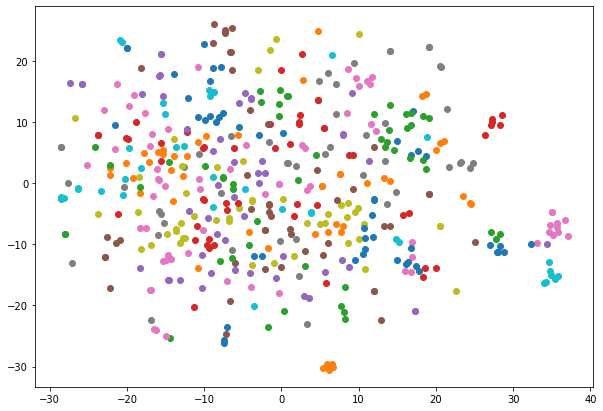

In [76]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

classes = np.unique(record[2])

for c in classes:
    i = np.where(np.array(record[2])==c)[0]
    plt.plot(X_tnse[i,0], X_tnse[i,1], 'o')

#### Consistency and relevance

For a given random video, we check **if the nearest videos are similar**

In [129]:
nn = NearestNeighbors()
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

we choose a random video: 

videos/v_CuttingInKitchen_g11_c04.avi


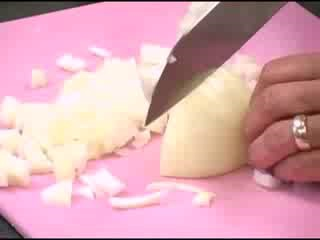

In [78]:
from IPython.display import Image

v = np.random.choice(len(record[0]), 1)[0]  # we choose a random video
video_name = record[0][v]

img = train[train.videos==video_name].frames.iloc[0][0]

print(record[0][v])
Image(img)

we compute the neighbors: 

In [79]:
neighbors = nn.kneighbors([X[v]])[1][0][1:]  

we display the nearest video: 

videos/v_CuttingInKitchen_g16_c02.avi


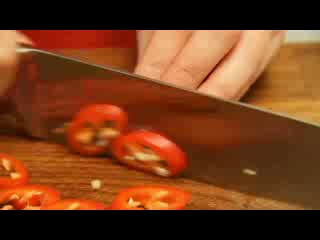

In [80]:
print(record[0][neighbors[0]])
img = train[train.videos==record[0][neighbors[0]]].frames.iloc[0][0]
Image(img)

we check the categories of the top-4 nearest videos:

In [81]:
for i in neighbors:
    print(record[0][i])

videos/v_CuttingInKitchen_g16_c02.avi
videos/v_SkyDiving_g24_c04.avi
videos/v_Skiing_g14_c01.avi
videos/v_Skiing_g15_c02.avi


**we compute top1 & top2 accuracy**

In [82]:
a1 = 0
a2 = 0
n = len(record[0])

for v in range(len(record[0])):
    
    video_name = record[0][v]  
    category = train[train.videos==video_name].targets.iloc[0]
    
    neighbors = nn.kneighbors([X[v]])[1][0][1:]
    
    category1 = train[train.videos==record[0][neighbors[0]]].targets.iloc[0]
    category2 = train[train.videos==record[0][neighbors[1]]].targets.iloc[0]

    if category==category1:
        a1+=1/n
    if category==category1 or category==category2:
        a2+=1/n

In [83]:
print("top1-accuracy", a1)
print("top2-accuracy", a2)

top1-accuracy 0.5000000000000003
top2-accuracy 0.5740000000000004


## 3.b. LSTM auto-encoders

Unlike the average pooling, the LSTM (aka Long Short Term Memory) auto-encoder take into account the **sequential order of the frames**. In this version, the **encoder** encodes the sequence of frames into a fixed-length vector (here 2048) and the **decoder** tries to decode it to recreate the input sequence **with minimum error**. Once the architecture is fitted, we can remove the decoder and use the encoder to get the representation of a video.

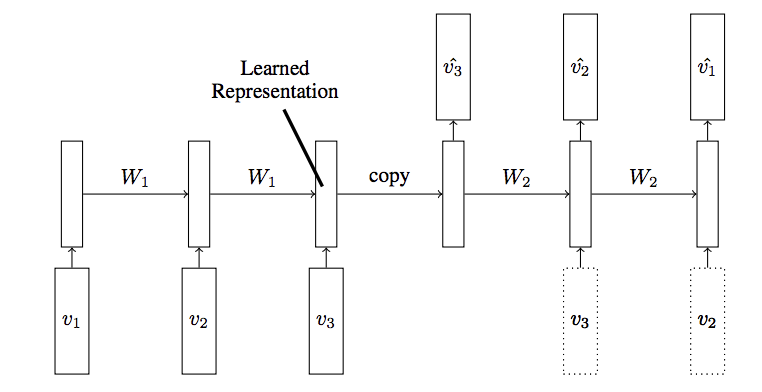

In [2]:
Image("pictures/lstm-ae.png")

**WARNING**: what follows is a little bit overkill for this specific usecase. Normally, we use LSTM auto-encoders for longer and/or more complex videos.

In [8]:
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.0.0


*TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. This makes it easy to get started with TensorFlow and debug models*

### video preparation

#### train and test information loading

In [9]:
dataset = dict()

for task in ["train", "test"]:
    dataset[task] = pd.read_json("{}.json".format(task))

#### cropping and 0-padding

we **crop** the videos (we keep 10 frames) and for shorter videos, we **pad missing frames with value "0"**

In [10]:
def crop(embeddings, cut=10):
    
    """
    This function crops and pads the multi-dimensional sequential 
    representations of the videos.
    """
    
    print("padding...")
    
    cropped_embeddings = []
    
    for x in embeddings:
        
        n_pad = cut - len(x[:cut])
        
        x_crop = np.pad(x[:cut], 
                        [(0, n_pad), (0, 0)], 
                        'constant',
                        constant_values=0)
        
        cropped_embeddings.append(x_crop)
    
    return cropped_embeddings

#### (Sequential) TF records

We define a function that will write **TF-records** of video batches. We will use this format to fit our LSTM auto-encoder for **low memory usage** (as video batches will be loaded on-the-fly while fitting the neural network) ! As a video is a sequential type of data (like time series), we save our tf records using *tf.train.SequenceExample*

In [5]:
def write_seqtfrecords(filepath, data):
    
    """
    This function writes the sequential tf-records, with keys:
    - video filenames 
    - video categories 
    - video binarized categories 
    - video embeddings for each frames
    """

    print("writting {}...".format(filepath))

    writer = tf.io.TFRecordWriter(filepath)

    for i in range(len(data[0])):
        
        # context 
        features = dict()
        
        features["videos"] = tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[str.encode(data[0][i])])
        )
        features["targets"] = tf.train.Feature(
            bytes_list=tf.train.BytesList(value=[str.encode(data[2][i])])
        )
        features["labels"] = tf.train.Feature(
            int64_list=tf.train.Int64List(value=data[3][i])
        )

        # feature_lists
        E = [tf.train.FloatList(value=data[1][i][t,:].tolist()) 
             for t in range(data[1][i].shape[0])]
            
        embedding = tf.train.FeatureList(feature=[
            tf.train.Feature(float_list=e) for e in E])

        # sequence
        example = tf.train.SequenceExample(
            context=tf.train.Features(feature=features),
            feature_lists=tf.train.FeatureLists(feature_list={
                "embeddings": embedding
        }))
        
        writer.write(example.SerializeToString())

    writer.close()

In [15]:
def compute_tf_records(dataset, task, feature_extractor, binarizer, batch_size=64, cut=10):
    
    """
    This function runs the tf-records computation and writes them in the 
    folder preprocess.
    """
    
    data = dataset[task]
    data = data.sample(data.shape[0])
    
    n_batch = int(data.shape[0]/batch_size)+1

    for batch in tqdm(range(n_batch)):
    
        # compute batch record
        a = batch*batch_size
        b = min((batch+1)*batch_size, data.shape[0])

        (videos, embeddings, targets, labels) = compute_batch_record(data.iloc[a:b], 
                                                                     feature_extractor, 
                                                                     binarizer)

        # crop
        embeddings = crop(embeddings, cut)

        # write tf record 
        filepath = "preprocess/{}/seq_{}.tfrecord".format(task, batch)
        write_seqtfrecords(filepath, (videos, embeddings, targets, labels))

**we run the writting of TF records for train and test sets**: it will be saved in *preprocess/train* and *preprocess/test* folders.

**[DO NOT RUN]**

In [39]:
batch_size=504

for task in ["train", "test"]:
    print(task)
    compute_tf_records(dataset, task, feature_extractor, binarizer, batch_size=batch_size, cut=10)


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|          | 4/504 [00:00<00:15, 33.29it/s]

train
extracting the frames for 504 videos...




  2%|▏         | 9/504 [00:00<00:14, 34.43it/s]

  2%|▏         | 12/504 [00:00<00:15, 30.90it/s]

  3%|▎         | 15/504 [00:00<00:17, 28.19it/s]

  4%|▎         | 18/504 [00:00<00:18, 25.82it/s]

  4%|▍         | 21/504 [00:00<00:19, 24.36it/s]

  5%|▍         | 24/504 [00:00<00:21, 22.49it/s]

  5%|▌         | 27/504 [00:01<00:20, 22.75it/s]

  6%|▌         | 30/504 [00:01<00:22, 20.96it/s]

  8%|▊         | 38/504 [00:01<00:19, 24.06it/s]

  8%|▊         | 42/504 [00:01<00:17, 27.00it/s]

  9%|▉         | 45/504 [00:01<00:18, 24.39it/s]

 10%|▉         | 49/504 [00:01<00:16, 26.78it/s]

 10%|█         | 52/504 [00:01<00:19, 23.00it/s]

 11%|█         | 56/504 [00:02<00:18, 24.82it/s]

 12%|█▏        | 62/504 [00:02<00:14, 30.04it/s]

 13%|█▎        | 66/504 [00:02<00:14, 29.27it/s]

 14%|█▍        | 71/504 [00:02<00:13, 31.19it/s]

 15%|█▍        | 75/504 [00:02<00:15, 27.64it/s]

 16%|█▌        | 81/504 [00:02<00:12, 32.82it/s]

 17%|█▋        | 85/504 [00:03<00:19, 21.85it/s]


computing the features for 504 videos...
padding...
writting preprocess/train/seq_0.tfrecord...



  5%|▌         | 1/19 [00:49<14:47, 49.30s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|          | 3/504 [00:00<00:25, 19.56it/s]

extracting the frames for 504 videos...




  1%|▏         | 7/504 [00:00<00:23, 21.49it/s]

  2%|▏         | 12/504 [00:00<00:20, 23.98it/s]

  3%|▎         | 15/504 [00:00<00:19, 25.43it/s]

  4%|▎         | 18/504 [00:00<00:18, 25.59it/s]

  4%|▍         | 21/504 [00:00<00:20, 23.42it/s]

  5%|▍         | 24/504 [00:01<00:23, 20.04it/s]

  5%|▌         | 26/504 [00:01<00:28, 16.67it/s]

  6%|▌         | 28/504 [00:01<00:31, 15.26it/s]

  6%|▋         | 32/504 [00:01<00:28, 16.40it/s]

  7%|▋         | 36/504 [00:01<00:24, 19.16it/s]

  8%|▊         | 40/504 [00:01<00:20, 22.10it/s]

  9%|▉         | 45/504 [00:01<00:17, 25.59it/s]

 10%|▉         | 48/504 [00:02<00:17, 26.61it/s]

 10%|█         | 51/504 [00:02<00:17, 26.61it/s]

 11%|█         | 54/504 [00:02<00:16, 26.93it/s]

 11%|█▏        | 57/504 [00:02<00:21, 21.03it/s]

 12%|█▏        | 62/504 [00:02<00:17, 25.19it/s]

 13%|█▎        | 66/504 [00:02<00:22, 19.25it/s]

 14%|█▎        | 69/504 [00:03<00:26, 16.63it/s]

 14%|█▍        | 72/504 [00:03<00:26, 16.54it/s]


computing the features for 504 videos...
padding...
writting preprocess/train/seq_1.tfrecord...



 11%|█         | 2/19 [01:37<13:53, 49.04s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:28, 17.80it/s]

extracting the frames for 504 videos...




  1%|          | 3/504 [00:00<00:38, 13.04it/s]

  1%|▏         | 7/504 [00:00<00:30, 16.33it/s]

  2%|▏         | 10/504 [00:00<00:29, 16.65it/s]

  2%|▏         | 12/504 [00:00<00:29, 16.66it/s]

  3%|▎         | 15/504 [00:00<00:26, 18.65it/s]

  3%|▎         | 17/504 [00:00<00:35, 13.71it/s]

  4%|▍         | 21/504 [00:01<00:31, 15.35it/s]

  5%|▌         | 26/504 [00:01<00:26, 17.92it/s]

  6%|▌         | 29/504 [00:01<00:24, 19.02it/s]

  6%|▋         | 32/504 [00:01<00:25, 18.25it/s]

  7%|▋         | 35/504 [00:01<00:24, 18.96it/s]

  8%|▊         | 40/504 [00:01<00:21, 21.28it/s]

  9%|▊         | 43/504 [00:02<00:25, 17.86it/s]

  9%|▉         | 46/504 [00:02<00:23, 19.40it/s]

 10%|█         | 51/504 [00:02<00:21, 21.20it/s]

 11%|█         | 55/504 [00:02<00:19, 23.10it/s]

 12%|█▏        | 60/504 [00:02<00:17, 25.27it/s]

 12%|█▎        | 63/504 [00:02<00:17, 24.58it/s]

 13%|█▎        | 66/504 [00:03<00:17, 24.75it/s]

 14%|█▍        | 71/504 [00:03<00:15, 28.20it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_2.tfrecord...



 16%|█▌        | 3/19 [02:24<12:54, 48.43s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:26, 18.90it/s]

extracting the frames for 504 videos...




  1%|          | 5/504 [00:00<00:25, 19.37it/s]

  2%|▏         | 8/504 [00:00<00:24, 20.07it/s]

  2%|▏         | 10/504 [00:00<00:31, 15.74it/s]

  2%|▏         | 12/504 [00:00<00:33, 14.56it/s]

  3%|▎         | 14/504 [00:00<00:32, 15.06it/s]

  4%|▍         | 19/504 [00:00<00:26, 18.31it/s]

  5%|▍         | 24/504 [00:01<00:22, 21.69it/s]

  6%|▌         | 28/504 [00:01<00:19, 24.68it/s]

  6%|▌         | 31/504 [00:01<00:23, 20.15it/s]

  7%|▋         | 36/504 [00:01<00:19, 24.10it/s]

  8%|▊         | 40/504 [00:01<00:18, 24.95it/s]

  9%|▊         | 43/504 [00:01<00:22, 20.08it/s]

  9%|▉         | 46/504 [00:02<00:28, 16.35it/s]

 10%|▉         | 49/504 [00:02<00:26, 16.98it/s]

 11%|█         | 53/504 [00:02<00:23, 19.30it/s]

 11%|█         | 56/504 [00:02<00:25, 17.38it/s]

 12%|█▏        | 59/504 [00:02<00:23, 19.34it/s]

 13%|█▎        | 64/504 [00:02<00:18, 23.63it/s]

 13%|█▎        | 68/504 [00:03<00:17, 24.32it/s]

 14%|█▍        | 71/504 [00:03<00:22, 19.58it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_3.tfrecord...



 21%|██        | 4/19 [03:12<12:01, 48.09s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  2%|▏         | 8/504 [00:00<00:07, 64.96it/s]

extracting the frames for 504 videos...




  2%|▏         | 10/504 [00:00<00:18, 27.18it/s]

  3%|▎         | 14/504 [00:00<00:16, 29.05it/s]

  4%|▍         | 19/504 [00:00<00:14, 32.50it/s]

  4%|▍         | 22/504 [00:00<00:16, 28.66it/s]

  5%|▍         | 25/504 [00:00<00:17, 27.04it/s]

  6%|▌         | 28/504 [00:00<00:21, 21.65it/s]

  6%|▌         | 31/504 [00:01<00:26, 18.00it/s]

  7%|▋         | 34/504 [00:01<00:24, 19.12it/s]

  8%|▊         | 38/504 [00:01<00:21, 21.41it/s]

  9%|▊         | 43/504 [00:01<00:18, 25.40it/s]

  9%|▉         | 46/504 [00:01<00:20, 22.32it/s]

 10%|▉         | 49/504 [00:02<00:29, 15.42it/s]

 11%|█         | 53/504 [00:02<00:25, 17.51it/s]

 11%|█         | 56/504 [00:02<00:25, 17.25it/s]

 12%|█▏        | 59/504 [00:02<00:23, 18.71it/s]

 12%|█▏        | 62/504 [00:02<00:21, 20.36it/s]

 13%|█▎        | 68/504 [00:02<00:17, 25.12it/s]

 14%|█▍        | 72/504 [00:03<00:19, 21.62it/s]

 15%|█▌        | 77/504 [00:03<00:17, 24.37it/s]

 16%|█▌        | 80/504 [00:03<00:19, 21.63it/s]

computing the features for 504 videos...
padding...
writting preprocess/train/seq_4.tfrecord...



 26%|██▋       | 5/19 [03:58<11:08, 47.74s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|          | 3/504 [00:00<00:28, 17.60it/s]

extracting the frames for 504 videos...




  1%|          | 6/504 [00:00<00:29, 17.09it/s]

  2%|▏         | 8/504 [00:00<00:30, 16.03it/s]

  2%|▏         | 10/504 [00:00<00:29, 16.83it/s]

  2%|▏         | 12/504 [00:00<00:28, 17.24it/s]

  3%|▎         | 17/504 [00:00<00:22, 21.23it/s]

  4%|▍         | 20/504 [00:01<00:25, 19.05it/s]

  5%|▍         | 23/504 [00:01<00:28, 16.81it/s]

  6%|▌         | 28/504 [00:01<00:24, 19.68it/s]

  7%|▋         | 33/504 [00:01<00:20, 23.52it/s]

  7%|▋         | 36/504 [00:01<00:20, 23.07it/s]

  8%|▊         | 42/504 [00:01<00:19, 23.86it/s]

  9%|▉         | 45/504 [00:02<00:24, 18.89it/s]

 10%|▉         | 48/504 [00:02<00:24, 18.67it/s]

 10%|█         | 52/504 [00:02<00:20, 21.88it/s]

 11%|█         | 55/504 [00:02<00:19, 22.56it/s]

 12%|█▏        | 58/504 [00:02<00:22, 19.94it/s]

 12%|█▏        | 61/504 [00:02<00:22, 19.83it/s]

 13%|█▎        | 64/504 [00:02<00:20, 21.69it/s]

 14%|█▍        | 70/504 [00:03<00:17, 24.21it/s]

 14%|█▍        | 73/504 [00:03<00:18, 23.67it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_5.tfrecord...



 32%|███▏      | 6/19 [04:45<10:15, 47.33s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

extracting the frames for 504 videos...




  0%|          | 2/504 [00:00<00:59,  8.39it/s]

  1%|▏         | 7/504 [00:00<00:46, 10.80it/s]

  2%|▏         | 9/504 [00:00<00:43, 11.37it/s]

  2%|▏         | 11/504 [00:00<00:40, 12.03it/s]

  3%|▎         | 14/504 [00:00<00:36, 13.38it/s]

  3%|▎         | 16/504 [00:00<00:34, 14.00it/s]

  4%|▍         | 21/504 [00:01<00:27, 17.27it/s]

  5%|▍         | 24/504 [00:01<00:28, 16.77it/s]

  5%|▌         | 27/504 [00:01<00:24, 19.14it/s]

  6%|▋         | 32/504 [00:01<00:20, 23.05it/s]

  7%|▋         | 35/504 [00:01<00:19, 23.65it/s]

  8%|▊         | 38/504 [00:01<00:23, 19.93it/s]

  8%|▊         | 41/504 [00:01<00:22, 20.73it/s]

  9%|▊         | 44/504 [00:02<00:25, 17.95it/s]

 10%|▉         | 48/504 [00:02<00:23, 19.75it/s]

 11%|█         | 53/504 [00:02<00:19, 22.73it/s]

 11%|█         | 56/504 [00:02<00:19, 23.08it/s]

 12%|█▏        | 59/504 [00:02<00:19, 22.75it/s]

 12%|█▎        | 63/504 [00:02<00:18, 24.12it/s]

 13%|█▎        | 68/504 [00:03<00:17, 24.97it/s]

 

computing the features for 504 videos...
padding...
writting preprocess/train/seq_6.tfrecord...



 37%|███▋      | 7/19 [05:30<09:20, 46.75s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 1/504 [00:00<01:30,  5.54it/s]

extracting the frames for 504 videos...




  1%|          | 3/504 [00:00<01:14,  6.75it/s]

  1%|▏         | 7/504 [00:00<00:57,  8.69it/s]

  2%|▏         | 11/504 [00:00<00:43, 11.34it/s]

  3%|▎         | 13/504 [00:00<00:37, 13.00it/s]

  3%|▎         | 16/504 [00:00<00:32, 14.99it/s]

  4%|▍         | 19/504 [00:01<00:31, 15.19it/s]

  4%|▍         | 22/504 [00:01<00:28, 16.86it/s]

  5%|▍         | 25/504 [00:01<00:26, 18.17it/s]

  6%|▌         | 28/504 [00:01<00:25, 18.73it/s]

  7%|▋         | 34/504 [00:01<00:21, 21.94it/s]

  7%|▋         | 37/504 [00:01<00:20, 23.32it/s]

  8%|▊         | 40/504 [00:01<00:22, 20.53it/s]

  9%|▊         | 44/504 [00:02<00:23, 19.96it/s]

 10%|▉         | 48/504 [00:02<00:19, 22.90it/s]

 10%|█         | 51/504 [00:02<00:20, 22.46it/s]

 11%|█         | 54/504 [00:02<00:21, 20.87it/s]

 11%|█▏        | 57/504 [00:02<00:25, 17.57it/s]

 12%|█▏        | 59/504 [00:02<00:27, 16.04it/s]

 12%|█▏        | 62/504 [00:03<00:26, 16.57it/s]

 13%|█▎        | 67/504 [00:03<00:22, 19.82it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_7.tfrecord...



 42%|████▏     | 8/19 [06:16<08:29, 46.31s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:28, 17.68it/s]

extracting the frames for 504 videos...




  1%|          | 5/504 [00:00<00:27, 18.32it/s]

  2%|▏         | 8/504 [00:00<00:26, 18.94it/s]

  2%|▏         | 11/504 [00:00<00:23, 21.04it/s]

  3%|▎         | 13/504 [00:00<00:32, 15.20it/s]

  3%|▎         | 15/504 [00:00<00:33, 14.47it/s]

  3%|▎         | 17/504 [00:00<00:31, 15.49it/s]

  4%|▍         | 21/504 [00:01<00:25, 18.93it/s]

  5%|▍         | 25/504 [00:01<00:22, 21.51it/s]

  6%|▌         | 30/504 [00:01<00:18, 25.71it/s]

  7%|▋         | 34/504 [00:01<00:19, 23.55it/s]

  8%|▊         | 38/504 [00:01<00:18, 25.11it/s]

  8%|▊         | 41/504 [00:01<00:18, 24.82it/s]

  9%|▊         | 44/504 [00:01<00:18, 25.38it/s]

  9%|▉         | 47/504 [00:02<00:20, 22.42it/s]

 10%|▉         | 50/504 [00:02<00:26, 17.37it/s]

 11%|█         | 53/504 [00:02<00:25, 17.59it/s]

 11%|█         | 56/504 [00:02<00:22, 20.08it/s]

 12%|█▏        | 59/504 [00:02<00:27, 16.38it/s]

 13%|█▎        | 67/504 [00:03<00:20, 20.88it/s]

 14%|█▍        | 71/504 [00:03<00:29, 14.43it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_8.tfrecord...



 47%|████▋     | 9/19 [07:02<07:43, 46.34s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:41, 12.15it/s]

extracting the frames for 504 videos...




  1%|          | 6/504 [00:00<00:32, 15.18it/s]

  2%|▏         | 8/504 [00:00<00:33, 14.63it/s]

  2%|▏         | 12/504 [00:00<00:27, 17.97it/s]

  3%|▎         | 15/504 [00:00<00:29, 16.44it/s]

  3%|▎         | 17/504 [00:00<00:30, 16.00it/s]

  4%|▍         | 21/504 [00:00<00:24, 19.47it/s]

  5%|▍         | 24/504 [00:01<00:23, 20.67it/s]

  5%|▌         | 27/504 [00:01<00:21, 21.72it/s]

  6%|▌         | 30/504 [00:01<00:20, 23.55it/s]

  7%|▋         | 33/504 [00:01<00:23, 20.35it/s]

  7%|▋         | 36/504 [00:01<00:22, 21.03it/s]

  8%|▊         | 41/504 [00:01<00:18, 25.26it/s]

  9%|▉         | 45/504 [00:02<00:21, 21.14it/s]

 10%|▉         | 48/504 [00:02<00:24, 18.78it/s]

 10%|█         | 51/504 [00:02<00:23, 18.95it/s]

 11%|█         | 54/504 [00:02<00:25, 17.95it/s]

 11%|█▏        | 57/504 [00:02<00:23, 19.05it/s]

 12%|█▏        | 60/504 [00:02<00:21, 21.08it/s]

 12%|█▎        | 63/504 [00:02<00:20, 21.02it/s]

 13%|█▎        | 66/504 [00:03<00:20, 21.71it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_9.tfrecord...



 53%|█████▎    | 10/19 [07:48<06:55, 46.20s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|          | 5/504 [00:00<00:18, 27.53it/s]

extracting the frames for 504 videos...




  2%|▏         | 8/504 [00:00<00:18, 26.85it/s]

  2%|▏         | 10/504 [00:00<00:22, 22.21it/s]

  2%|▏         | 12/504 [00:00<00:26, 18.59it/s]

  3%|▎         | 15/504 [00:00<00:24, 19.59it/s]

  4%|▎         | 18/504 [00:00<00:23, 20.60it/s]

  4%|▍         | 20/504 [00:00<00:25, 19.21it/s]

  5%|▌         | 26/504 [00:01<00:20, 23.04it/s]

  6%|▌         | 29/504 [00:01<00:25, 18.88it/s]

  7%|▋         | 34/504 [00:01<00:20, 23.09it/s]

  7%|▋         | 37/504 [00:01<00:18, 24.78it/s]

  8%|▊         | 40/504 [00:01<00:21, 21.76it/s]

  9%|▊         | 44/504 [00:01<00:18, 24.81it/s]

 10%|▉         | 49/504 [00:01<00:17, 26.23it/s]

 11%|█         | 54/504 [00:02<00:16, 27.77it/s]

 12%|█▏        | 58/504 [00:02<00:22, 19.69it/s]

 12%|█▏        | 61/504 [00:02<00:20, 21.63it/s]

 13%|█▎        | 64/504 [00:02<00:22, 19.90it/s]

 13%|█▎        | 68/504 [00:02<00:18, 23.21it/s]

 14%|█▍        | 71/504 [00:02<00:18, 23.70it/s]

 15%|█▍        | 74/504 [00:03<00:17, 24.58it/s]


computing the features for 504 videos...
padding...
writting preprocess/train/seq_10.tfrecord...



 58%|█████▊    | 11/19 [08:35<06:11, 46.43s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:33, 14.93it/s]

extracting the frames for 504 videos...




  1%|▏         | 7/504 [00:00<00:26, 18.75it/s]

  3%|▎         | 13/504 [00:00<00:21, 23.04it/s]

  4%|▎         | 18/504 [00:00<00:20, 24.29it/s]

  4%|▍         | 21/504 [00:00<00:22, 21.69it/s]

  5%|▌         | 26/504 [00:00<00:18, 26.10it/s]

  6%|▌         | 30/504 [00:01<00:19, 24.15it/s]

  7%|▋         | 36/504 [00:01<00:16, 28.06it/s]

  8%|▊         | 40/504 [00:01<00:22, 20.51it/s]

  9%|▊         | 44/504 [00:01<00:20, 22.94it/s]

 10%|▉         | 48/504 [00:01<00:17, 26.11it/s]

 10%|█         | 52/504 [00:01<00:21, 21.13it/s]

 11%|█         | 55/504 [00:02<00:21, 20.54it/s]

 12%|█▏        | 58/504 [00:02<00:21, 20.49it/s]

 12%|█▎        | 63/504 [00:02<00:19, 22.45it/s]

 13%|█▎        | 66/504 [00:02<00:19, 22.85it/s]

 14%|█▎        | 69/504 [00:02<00:22, 19.65it/s]

 14%|█▍        | 72/504 [00:02<00:20, 20.90it/s]

 15%|█▍        | 75/504 [00:03<00:21, 20.11it/s]

 16%|█▌        | 81/504 [00:03<00:19, 22.24it/s]

 17%|█▋        | 84/504 [00:03<00:18, 23.01it/s]


computing the features for 504 videos...
padding...
writting preprocess/train/seq_11.tfrecord...



 63%|██████▎   | 12/19 [09:21<05:25, 46.46s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|          | 3/504 [00:00<00:18, 27.38it/s]

extracting the frames for 504 videos...




  1%|▏         | 7/504 [00:00<00:17, 28.38it/s]

  2%|▏         | 11/504 [00:00<00:17, 28.43it/s]

  3%|▎         | 13/504 [00:00<00:25, 19.58it/s]

  3%|▎         | 16/504 [00:00<00:25, 19.21it/s]

  4%|▍         | 19/504 [00:00<00:24, 19.47it/s]

  4%|▍         | 21/504 [00:00<00:25, 18.63it/s]

  5%|▍         | 23/504 [00:01<00:26, 18.14it/s]

  5%|▍         | 25/504 [00:01<00:26, 18.25it/s]

  5%|▌         | 27/504 [00:01<00:29, 16.39it/s]

  6%|▌         | 30/504 [00:01<00:25, 18.86it/s]

  7%|▋         | 37/504 [00:01<00:19, 23.81it/s]

  8%|▊         | 41/504 [00:01<00:21, 21.36it/s]

  9%|▉         | 45/504 [00:01<00:18, 24.67it/s]

 10%|▉         | 50/504 [00:02<00:17, 26.48it/s]

 11%|█         | 56/504 [00:02<00:14, 30.63it/s]

 12%|█▏        | 60/504 [00:02<00:14, 30.36it/s]

 13%|█▎        | 64/504 [00:02<00:19, 23.05it/s]

 14%|█▎        | 69/504 [00:02<00:16, 26.73it/s]

 15%|█▍        | 74/504 [00:02<00:15, 27.25it/s]

 15%|█▌        | 78/504 [00:03<00:21, 19.86it/s]


computing the features for 504 videos...
padding...
writting preprocess/train/seq_12.tfrecord...



 68%|██████▊   | 13/19 [10:06<04:35, 45.98s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:34, 14.74it/s]

extracting the frames for 504 videos...




  1%|          | 5/504 [00:00<00:30, 16.38it/s]

  2%|▏         | 9/504 [00:00<00:26, 18.42it/s]

  2%|▏         | 12/504 [00:00<00:24, 20.11it/s]

  3%|▎         | 14/504 [00:00<00:29, 16.69it/s]

  3%|▎         | 16/504 [00:00<00:28, 17.43it/s]

  4%|▎         | 18/504 [00:00<00:28, 16.82it/s]

  4%|▍         | 22/504 [00:01<00:23, 20.22it/s]

  5%|▌         | 27/504 [00:01<00:22, 21.54it/s]

  6%|▌         | 31/504 [00:01<00:19, 23.86it/s]

  7%|▋         | 34/504 [00:01<00:25, 18.77it/s]

  7%|▋         | 37/504 [00:01<00:23, 19.73it/s]

  8%|▊         | 40/504 [00:01<00:22, 20.59it/s]

  9%|▊         | 43/504 [00:01<00:20, 22.39it/s]

  9%|▉         | 46/504 [00:02<00:20, 22.03it/s]

 10%|▉         | 49/504 [00:02<00:24, 18.81it/s]

 11%|█         | 53/504 [00:02<00:20, 21.89it/s]

 11%|█         | 56/504 [00:02<00:22, 19.72it/s]

 12%|█▏        | 59/504 [00:02<00:22, 19.48it/s]

 12%|█▏        | 62/504 [00:03<00:28, 15.56it/s]

 14%|█▎        | 69/504 [00:03<00:21, 20.11it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_13.tfrecord...



 74%|███████▎  | 14/19 [10:53<03:51, 46.33s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

extracting the frames for 504 videos...




  0%|          | 2/504 [00:00<00:59,  8.46it/s]

  1%|          | 4/504 [00:00<00:51,  9.78it/s]

  2%|▏         | 8/504 [00:00<00:41, 12.07it/s]

  3%|▎         | 13/504 [00:00<00:32, 15.13it/s]

  3%|▎         | 15/504 [00:00<00:32, 15.03it/s]

  3%|▎         | 17/504 [00:00<00:30, 16.07it/s]

  4%|▍         | 19/504 [00:01<00:30, 15.97it/s]

  4%|▍         | 21/504 [00:01<00:35, 13.55it/s]

  5%|▍         | 23/504 [00:01<00:33, 14.16it/s]

  5%|▍         | 25/504 [00:01<00:46, 10.19it/s]

  5%|▌         | 27/504 [00:01<00:53,  8.86it/s]

  6%|▌         | 30/504 [00:02<00:46, 10.10it/s]

  6%|▋         | 32/504 [00:02<00:42, 11.08it/s]

  7%|▋         | 35/504 [00:02<00:40, 11.72it/s]

  7%|▋         | 37/504 [00:02<00:35, 13.23it/s]

  8%|▊         | 40/504 [00:02<00:35, 13.03it/s]

  9%|▊         | 43/504 [00:03<00:32, 14.10it/s]

  9%|▉         | 45/504 [00:03<00:33, 13.79it/s]

  9%|▉         | 47/504 [00:03<00:37, 12.11it/s]

 10%|█         | 51/504 [00:03<00:31, 14.50it/s]

 

computing the features for 504 videos...
padding...
writting preprocess/train/seq_14.tfrecord...



 79%|███████▉  | 15/19 [11:47<03:14, 48.69s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:33, 15.12it/s]

extracting the frames for 504 videos...




  1%|          | 3/504 [00:00<00:38, 13.08it/s]

  1%|          | 6/504 [00:00<00:32, 15.09it/s]

  2%|▏         | 8/504 [00:00<00:37, 13.20it/s]

  2%|▏         | 12/504 [00:00<00:30, 16.23it/s]

  3%|▎         | 16/504 [00:00<00:26, 18.53it/s]

  4%|▍         | 20/504 [00:01<00:25, 18.89it/s]

  5%|▍         | 24/504 [00:01<00:25, 18.96it/s]

  5%|▌         | 27/504 [00:01<00:24, 19.36it/s]

  6%|▌         | 30/504 [00:01<00:24, 19.09it/s]

  6%|▋         | 32/504 [00:01<00:28, 16.78it/s]

  7%|▋         | 35/504 [00:01<00:26, 17.93it/s]

  8%|▊         | 39/504 [00:01<00:22, 21.11it/s]

  8%|▊         | 42/504 [00:02<00:22, 20.62it/s]

  9%|▉         | 45/504 [00:02<00:20, 22.16it/s]

 10%|▉         | 48/504 [00:02<00:19, 23.96it/s]

 10%|█         | 51/504 [00:02<00:22, 20.51it/s]

 11%|█         | 54/504 [00:02<00:21, 20.72it/s]

 11%|█▏        | 57/504 [00:02<00:21, 21.12it/s]

 12%|█▏        | 60/504 [00:02<00:21, 20.74it/s]

 12%|█▎        | 63/504 [00:03<00:20, 21.41it/s]

 

computing the features for 504 videos...
padding...
writting preprocess/train/seq_15.tfrecord...



 84%|████████▍ | 16/19 [12:36<02:25, 48.59s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

extracting the frames for 504 videos...




  0%|          | 1/504 [00:00<01:46,  4.72it/s]

  1%|          | 3/504 [00:00<01:22,  6.04it/s]

  1%|          | 5/504 [00:00<01:06,  7.47it/s]

  1%|          | 6/504 [00:00<01:07,  7.36it/s]

  2%|▏         | 8/504 [00:00<00:54,  9.07it/s]

  2%|▏         | 11/504 [00:00<00:44, 11.05it/s]

  3%|▎         | 13/504 [00:00<00:40, 12.15it/s]

  3%|▎         | 16/504 [00:01<00:34, 14.15it/s]

  4%|▎         | 18/504 [00:01<00:31, 15.51it/s]

  4%|▍         | 20/504 [00:01<00:38, 12.46it/s]

  5%|▍         | 24/504 [00:01<00:33, 14.30it/s]

  5%|▌         | 26/504 [00:01<00:32, 14.53it/s]

  6%|▌         | 29/504 [00:01<00:30, 15.41it/s]

  6%|▌         | 31/504 [00:02<00:35, 13.26it/s]

  7%|▋         | 34/504 [00:02<00:30, 15.65it/s]

  8%|▊         | 38/504 [00:02<00:25, 18.09it/s]

  8%|▊         | 41/504 [00:02<00:25, 18.15it/s]

  9%|▊         | 44/504 [00:02<00:28, 15.96it/s]

  9%|▉         | 47/504 [00:02<00:27, 16.46it/s]

 10%|▉         | 50/504 [00:03<00:23, 18.96it/s]

 11

computing the features for 504 videos...
padding...
writting preprocess/train/seq_16.tfrecord...



 89%|████████▉ | 17/19 [13:29<01:40, 50.03s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  0%|          | 2/504 [00:00<00:38, 12.89it/s]

extracting the frames for 504 videos...




  1%|          | 6/504 [00:00<00:32, 15.34it/s]

  2%|▏         | 9/504 [00:00<00:31, 15.88it/s]

  2%|▏         | 12/504 [00:00<00:26, 18.23it/s]

  3%|▎         | 14/504 [00:00<00:27, 17.91it/s]

  3%|▎         | 16/504 [00:00<00:29, 16.69it/s]

  4%|▍         | 19/504 [00:00<00:27, 17.73it/s]

  4%|▍         | 22/504 [00:01<00:25, 19.23it/s]

  5%|▍         | 25/504 [00:01<00:26, 18.22it/s]

  6%|▌         | 28/504 [00:01<00:28, 16.47it/s]

  6%|▌         | 30/504 [00:01<00:28, 16.91it/s]

  7%|▋         | 33/504 [00:01<00:30, 15.20it/s]

  7%|▋         | 36/504 [00:01<00:26, 17.61it/s]

  8%|▊         | 38/504 [00:02<00:28, 16.49it/s]

  8%|▊         | 40/504 [00:02<00:27, 16.77it/s]

  9%|▊         | 44/504 [00:02<00:23, 19.29it/s]

  9%|▉         | 47/504 [00:02<00:23, 19.22it/s]

 10%|▉         | 50/504 [00:02<00:26, 16.89it/s]

 11%|█         | 53/504 [00:02<00:23, 18.99it/s]

 11%|█         | 56/504 [00:03<00:25, 17.64it/s]

 12%|█▏        | 58/504 [00:03<00:27, 16.34it/s]



computing the features for 504 videos...
padding...
writting preprocess/train/seq_17.tfrecord...



 95%|█████████▍| 18/19 [14:19<00:49, 49.94s/it]

  0%|          | 0/465 [00:00<?, ?it/s]

  1%|          | 4/465 [00:00<00:15, 30.05it/s]

extracting the frames for 465 videos...




  2%|▏         | 7/465 [00:00<00:15, 29.20it/s]

  2%|▏         | 9/465 [00:00<00:21, 21.46it/s]

  2%|▏         | 11/465 [00:00<00:24, 18.42it/s]

  3%|▎         | 16/465 [00:00<00:21, 21.10it/s]

  4%|▍         | 18/465 [00:00<00:23, 18.92it/s]

  4%|▍         | 20/465 [00:00<00:25, 17.45it/s]

  6%|▌         | 26/465 [00:01<00:21, 20.11it/s]

  6%|▌         | 29/465 [00:01<00:23, 18.67it/s]

  7%|▋         | 31/465 [00:01<00:31, 13.87it/s]

  7%|▋         | 34/465 [00:01<00:28, 15.14it/s]

  8%|▊         | 36/465 [00:01<00:31, 13.81it/s]

  8%|▊         | 38/465 [00:02<00:28, 15.16it/s]

  9%|▊         | 40/465 [00:02<00:28, 15.12it/s]

  9%|▉         | 43/465 [00:02<00:28, 14.81it/s]

 10%|▉         | 46/465 [00:02<00:24, 17.04it/s]

 11%|█         | 50/465 [00:02<00:21, 19.03it/s]

 11%|█▏        | 53/465 [00:02<00:22, 18.00it/s]

 12%|█▏        | 55/465 [00:02<00:24, 16.93it/s]

 12%|█▏        | 57/465 [00:03<00:23, 17.11it/s]

 13%|█▎        | 60/465 [00:03<00:25, 15.88it/s]



computing the features for 465 videos...
padding...
writting preprocess/train/seq_18.tfrecord...



100%|██████████| 19/19 [15:06<00:00, 47.73s/it]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|          | 4/504 [00:00<00:13, 37.62it/s]

test
extracting the frames for 504 videos...




  3%|▎         | 13/504 [00:00<00:10, 45.20it/s]

  4%|▍         | 22/504 [00:00<00:09, 52.09it/s]

  6%|▋         | 32/504 [00:00<00:07, 60.55it/s]

  8%|▊         | 42/504 [00:00<00:06, 68.15it/s]

 10%|█         | 51/504 [00:00<00:06, 71.40it/s]

 13%|█▎        | 64/504 [00:00<00:05, 81.20it/s]

 14%|█▍        | 73/504 [00:00<00:05, 83.52it/s]

 17%|█▋        | 84/504 [00:00<00:04, 87.41it/s]

 19%|█▉        | 95/504 [00:01<00:04, 91.78it/s]

 21%|██        | 105/504 [00:01<00:04, 92.01it/s]

 23%|██▎       | 115/504 [00:01<00:04, 85.08it/s]

 25%|██▍       | 124/504 [00:01<00:04, 77.41it/s]

 27%|██▋       | 135/504 [00:01<00:04, 82.88it/s]

 29%|██▊       | 144/504 [00:01<00:04, 84.79it/s]

 31%|███       | 154/504 [00:01<00:04, 84.25it/s]

 32%|███▏      | 163/504 [00:01<00:04, 83.95it/s]

 34%|███▍      | 172/504 [00:02<00:04, 82.36it/s]

 36%|███▌      | 181/504 [00:02<00:03, 82.62it/s]

 38%|███▊      | 190/504 [00:02<00:03, 78.85it/s]

 39%|███▉      | 199/504 [00:02<00:03,

computing the features for 504 videos...
padding...
writting preprocess/test/seq_0.tfrecord...



 12%|█▎        | 1/8 [00:30<03:32, 30.33s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  2%|▏         | 8/504 [00:00<00:07, 66.84it/s]

extracting the frames for 504 videos...




  4%|▍         | 20/504 [00:00<00:06, 76.09it/s]

  6%|▌         | 29/504 [00:00<00:06, 75.49it/s]

  8%|▊         | 39/504 [00:00<00:06, 76.82it/s]

  9%|▉         | 46/504 [00:00<00:06, 72.63it/s]

 11%|█         | 53/504 [00:00<00:06, 71.02it/s]

 12%|█▏        | 62/504 [00:00<00:05, 75.68it/s]

 14%|█▍        | 72/504 [00:00<00:05, 79.34it/s]

 16%|█▌        | 80/504 [00:01<00:05, 76.26it/s]

 18%|█▊        | 89/504 [00:01<00:05, 78.23it/s]

 19%|█▉        | 97/504 [00:01<00:05, 78.20it/s]

 21%|██        | 105/504 [00:01<00:05, 74.39it/s]

 23%|██▎       | 114/504 [00:01<00:05, 74.59it/s]

 24%|██▍       | 122/504 [00:01<00:05, 75.72it/s]

 26%|██▋       | 133/504 [00:01<00:04, 82.02it/s]

 29%|██▉       | 145/504 [00:01<00:03, 90.12it/s]

 31%|███       | 155/504 [00:01<00:04, 81.10it/s]

 33%|███▎      | 165/504 [00:02<00:03, 85.44it/s]

 35%|███▍      | 174/504 [00:02<00:04, 78.59it/s]

 37%|███▋      | 186/504 [00:02<00:03, 87.00it/s]

 39%|███▉      | 196/504 [00:02<00:03, 

computing the features for 504 videos...
padding...
writting preprocess/test/seq_1.tfrecord...



 25%|██▌       | 2/8 [00:59<03:00, 30.06s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  2%|▏         | 11/504 [00:00<00:04, 109.68it/s]

extracting the frames for 504 videos...




  5%|▍         | 23/504 [00:00<00:04, 108.88it/s]

  7%|▋         | 33/504 [00:00<00:04, 103.58it/s]

  9%|▊         | 44/504 [00:00<00:04, 103.22it/s]

 11%|█         | 53/504 [00:00<00:04, 97.96it/s] 

 12%|█▎        | 63/504 [00:00<00:04, 96.85it/s]

 14%|█▍        | 73/504 [00:00<00:04, 97.66it/s]

 17%|█▋        | 86/504 [00:00<00:04, 103.04it/s]

 19%|█▉        | 97/504 [00:00<00:03, 104.92it/s]

 21%|██▏       | 108/504 [00:01<00:03, 102.07it/s]

 23%|██▎       | 118/504 [00:01<00:04, 88.82it/s] 

 25%|██▌       | 128/504 [00:01<00:04, 86.94it/s]

 27%|██▋       | 137/504 [00:01<00:04, 78.42it/s]

 29%|██▉       | 146/504 [00:01<00:04, 81.30it/s]

 31%|███       | 157/504 [00:01<00:03, 86.79it/s]

 33%|███▎      | 168/504 [00:01<00:03, 91.34it/s]

 36%|███▌      | 181/504 [00:01<00:03, 98.41it/s]

 38%|███▊      | 194/504 [00:01<00:02, 105.03it/s]

 41%|████      | 205/504 [00:02<00:02, 101.20it/s]

 43%|████▎     | 216/504 [00:02<00:02, 101.70it/s]

 45%|████▌     | 227/504 [

computing the features for 504 videos...
padding...
writting preprocess/test/seq_2.tfrecord...



 38%|███▊      | 3/8 [01:29<02:29, 29.99s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  2%|▏         | 8/504 [00:00<00:06, 78.19it/s]

extracting the frames for 504 videos...




  4%|▎         | 18/504 [00:00<00:05, 81.93it/s]

  6%|▌         | 28/504 [00:00<00:05, 85.32it/s]

  7%|▋         | 36/504 [00:00<00:05, 83.22it/s]

 10%|▉         | 49/504 [00:00<00:04, 92.64it/s]

 12%|█▏        | 59/504 [00:00<00:04, 94.71it/s]

 14%|█▍        | 71/504 [00:00<00:04, 100.14it/s]

 17%|█▋        | 84/504 [00:00<00:03, 107.43it/s]

 19%|█▉        | 95/504 [00:00<00:03, 103.29it/s]

 21%|██        | 107/504 [00:01<00:03, 105.29it/s]

 24%|██▎       | 119/504 [00:01<00:03, 106.12it/s]

 26%|██▌       | 130/504 [00:01<00:03, 101.07it/s]

 28%|██▊       | 141/504 [00:01<00:03, 101.04it/s]

 30%|███       | 152/504 [00:01<00:03, 97.70it/s] 

 32%|███▏      | 163/504 [00:01<00:03, 98.35it/s]

 35%|███▍      | 174/504 [00:01<00:03, 101.06it/s]

 37%|███▋      | 185/504 [00:01<00:03, 100.52it/s]

 39%|███▉      | 196/504 [00:02<00:03, 86.27it/s] 

 41%|████      | 206/504 [00:02<00:03, 82.69it/s]

 43%|████▎     | 215/504 [00:02<00:03, 83.44it/s]

 45%|████▌     | 227/504 [

computing the features for 504 videos...
padding...
writting preprocess/test/seq_3.tfrecord...



 50%|█████     | 4/8 [01:59<02:00, 30.01s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  2%|▏         | 10/504 [00:00<00:05, 84.15it/s]

extracting the frames for 504 videos...




  4%|▍         | 21/504 [00:00<00:05, 89.94it/s]

  6%|▋         | 32/504 [00:00<00:05, 92.69it/s]

  8%|▊         | 39/504 [00:00<00:05, 79.39it/s]

 10%|▉         | 49/504 [00:00<00:05, 83.41it/s]

 12%|█▏        | 58/504 [00:00<00:05, 83.89it/s]

 13%|█▎        | 67/504 [00:00<00:05, 83.83it/s]

 15%|█▌        | 76/504 [00:00<00:05, 85.42it/s]

 17%|█▋        | 85/504 [00:00<00:04, 84.42it/s]

 19%|█▊        | 94/504 [00:01<00:04, 83.01it/s]

 20%|██        | 103/504 [00:01<00:05, 78.15it/s]

 22%|██▏       | 111/504 [00:01<00:05, 74.41it/s]

 24%|██▍       | 120/504 [00:01<00:04, 77.07it/s]

 26%|██▌       | 129/504 [00:01<00:04, 80.08it/s]

 27%|██▋       | 138/504 [00:01<00:04, 79.34it/s]

 29%|██▉       | 146/504 [00:01<00:04, 73.14it/s]

 31%|███       | 154/504 [00:01<00:04, 72.56it/s]

 32%|███▏      | 162/504 [00:02<00:04, 74.52it/s]

 34%|███▎      | 170/504 [00:02<00:04, 67.51it/s]

 35%|███▌      | 177/504 [00:02<00:05, 65.31it/s]

 37%|███▋      | 188/504 [00:02<00:04,

computing the features for 504 videos...
padding...
writting preprocess/test/seq_4.tfrecord...



 62%|██████▎   | 5/8 [02:28<01:29, 29.67s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  1%|▏         | 7/504 [00:00<00:09, 51.47it/s]

extracting the frames for 504 videos...




  4%|▎         | 18/504 [00:00<00:08, 60.24it/s]

  5%|▌         | 26/504 [00:00<00:07, 63.58it/s]

  7%|▋         | 35/504 [00:00<00:06, 69.72it/s]

  9%|▊         | 43/504 [00:00<00:06, 70.95it/s]

 11%|█         | 54/504 [00:00<00:05, 77.98it/s]

 12%|█▎        | 63/504 [00:00<00:05, 80.71it/s]

 14%|█▍        | 72/504 [00:00<00:05, 81.93it/s]

 16%|█▋        | 82/504 [00:00<00:04, 86.62it/s]

 18%|█▊        | 91/504 [00:01<00:05, 80.50it/s]

 20%|██        | 101/504 [00:01<00:04, 85.40it/s]

 22%|██▏       | 110/504 [00:01<00:05, 78.05it/s]

 24%|██▎       | 119/504 [00:01<00:05, 70.65it/s]

 26%|██▌       | 129/504 [00:01<00:04, 75.38it/s]

 28%|██▊       | 141/504 [00:01<00:04, 84.76it/s]

 30%|██▉       | 151/504 [00:01<00:04, 76.27it/s]

 32%|███▏      | 160/504 [00:01<00:04, 79.72it/s]

 34%|███▎      | 169/504 [00:02<00:04, 82.52it/s]

 35%|███▌      | 178/504 [00:02<00:04, 81.06it/s]

 37%|███▋      | 188/504 [00:02<00:03, 83.66it/s]

 39%|███▉      | 198/504 [00:02<00:03,

computing the features for 504 videos...
padding...
writting preprocess/test/seq_5.tfrecord...



 75%|███████▌  | 6/8 [02:58<00:59, 29.88s/it]

  0%|          | 0/504 [00:00<?, ?it/s]

  3%|▎         | 14/504 [00:00<00:03, 132.41it/s]

extracting the frames for 504 videos...




  5%|▍         | 25/504 [00:00<00:04, 119.09it/s]

  8%|▊         | 38/504 [00:00<00:03, 121.51it/s]

 10%|▉         | 48/504 [00:00<00:04, 113.37it/s]

 11%|█▏        | 57/504 [00:00<00:04, 101.77it/s]

 13%|█▎        | 67/504 [00:00<00:04, 99.73it/s] 

 15%|█▌        | 76/504 [00:00<00:04, 87.82it/s]

 17%|█▋        | 85/504 [00:00<00:05, 82.32it/s]

 19%|█▉        | 96/504 [00:01<00:04, 86.48it/s]

 21%|██        | 107/504 [00:01<00:04, 90.50it/s]

 23%|██▎       | 116/504 [00:01<00:04, 83.21it/s]

 25%|██▍       | 125/504 [00:01<00:04, 80.67it/s]

 27%|██▋       | 134/504 [00:01<00:04, 78.09it/s]

 28%|██▊       | 142/504 [00:01<00:04, 78.59it/s]

 30%|██▉       | 150/504 [00:01<00:04, 77.27it/s]

 32%|███▏      | 160/504 [00:01<00:04, 82.73it/s]

 34%|███▍      | 171/504 [00:01<00:03, 87.76it/s]

 36%|███▌      | 180/504 [00:02<00:04, 80.16it/s]

 38%|███▊      | 189/504 [00:02<00:03, 81.87it/s]

 39%|███▉      | 198/504 [00:02<00:04, 70.96it/s]

 41%|████      | 207/504 [00:02<

computing the features for 504 videos...
padding...
writting preprocess/test/seq_6.tfrecord...



 88%|████████▊ | 7/8 [03:29<00:29, 29.99s/it]

  0%|          | 0/255 [00:00<?, ?it/s]

  2%|▏         | 6/255 [00:00<00:04, 54.31it/s]

extracting the frames for 255 videos...




  7%|▋         | 17/255 [00:00<00:03, 62.89it/s]

 10%|▉         | 25/255 [00:00<00:03, 67.15it/s]

 13%|█▎        | 33/255 [00:00<00:03, 67.63it/s]

 17%|█▋        | 44/255 [00:00<00:02, 75.77it/s]

 20%|██        | 52/255 [00:00<00:02, 75.54it/s]

 24%|██▍       | 61/255 [00:00<00:02, 78.28it/s]

 28%|██▊       | 72/255 [00:00<00:02, 84.31it/s]

 32%|███▏      | 81/255 [00:00<00:02, 84.96it/s]

 36%|███▌      | 91/255 [00:01<00:01, 88.22it/s]

 40%|███▉      | 101/255 [00:01<00:01, 88.99it/s]

 43%|████▎     | 110/255 [00:01<00:01, 83.39it/s]

 47%|████▋     | 120/255 [00:01<00:01, 84.26it/s]

 51%|█████     | 129/255 [00:01<00:01, 85.53it/s]

 54%|█████▍    | 138/255 [00:01<00:01, 78.73it/s]

 58%|█████▊    | 147/255 [00:01<00:01, 80.20it/s]

 61%|██████    | 156/255 [00:01<00:01, 79.69it/s]

 65%|██████▌   | 166/255 [00:01<00:01, 84.05it/s]

 69%|██████▊   | 175/255 [00:02<00:00, 80.50it/s]

 72%|███████▏  | 184/255 [00:02<00:00, 81.54it/s]

 76%|███████▌  | 193/255 [00:02<00:00,

computing the features for 255 videos...
padding...
writting preprocess/test/seq_7.tfrecord...



100%|██████████| 8/8 [03:44<00:00, 28.05s/it]


#### Now we fit the autoencoder using the tf records

We **read** the sequential TF record

In [17]:
def read_seqtfrecords(filepath, batch_size=64):
    
    """
    This function reads the sequential tf-records.
    """
    
    # we define our dict of features
    context_features = dict()
    context_features["videos"] = tf.io.FixedLenFeature([1], tf.string)
    context_features["targets"] = tf.io.FixedLenFeature([1], tf.string)
    context_features["labels"] = tf.io.FixedLenFeature([101], tf.int64)
    
    sequence_features = dict()
    sequence_features["embeddings"] = tf.io.FixedLenSequenceFeature([2048], tf.float32)
    
    # we define the parser
    def customized_parser(record, context_features, sequence_features):
        parsed = tf.io.parse_single_sequence_example(serialized=record, 
                                                     context_features=context_features,
                                                     sequence_features=sequence_features)
        
        return parsed

    def tfrecord_dataset(filepath):
        buffer_size = 8 * 1024 * 1024
        return tf.data.TFRecordDataset(filepath, buffer_size=buffer_size)

    # we list all the tf records files in the filepath folder
    files = tf.data.Dataset.list_files(filepath + "/*.tfrecord")
    dataset = files.apply(
        tf.data.experimental.parallel_interleave(
            tfrecord_dataset, cycle_length=8, sloppy=True
        )
    )
    
    # we read the files (parallelized)
    dataset = dataset.map(
        lambda record: customized_parser(record, context_features, sequence_features),
        num_parallel_calls=8,
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(4)

    training_iterator = dataset.make_one_shot_iterator()

    next_element = training_iterator.get_next()

    return next_element

we can (easily) test our function to see if everything is ok... Thank you Tensorflow 2.0 !

In [148]:
batch_size = 32 

sample = read_seqtfrecords("preprocess/train", batch_size)

sample[1]["embeddings"].shape

TensorShape([32, 10, 2048])

In [149]:
timesteps = sample[1]["embeddings"].shape[1]
n_features = sample[1]["embeddings"].shape[2]

we build our **LSTM auto encoder**. We need to **mask the 0-padding** for the reconstruction error (here mse) 

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Masking
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.models import Model

In [22]:
# define model
dim = 2048 

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(timesteps, n_features)))
model.add(LSTM(dim, activation='relu'))
#model.add(LSTM(dim, activation='relu', input_shape=(timesteps, n_features)))
model.add(RepeatVector(timesteps))
model.add(LSTM(dim, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 10, 2048)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 2048)              33562624  
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 2048)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 2048)          33562624  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 2048)          4196352   
Total params: 71,321,600
Trainable params: 71,321,600
Non-trainable params: 0
_________________________________________________________________


we **fit** the auto encoder and then **remove the decoder part**

**[DO NOT RUN LOCALLY]**

In [ ]:
epochs = 10
n_batch = int(dataset["train"].shape[0]/batch_size)+1

model.fit(x=sample[1]["embeddings"], 
          y=sample[1]["embeddings"], 
          steps_per_epoch=n_batch,
          epochs=epochs)

Epoch 1/15
215/299 [====================>.........] - ETA: 24s - loss: 0.1524

In [ ]:
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
# model.save_weights('lstm-ae.h5')

we **encode** some samples

In [24]:
# model.load_weights('lstm-ae.h5')

In [112]:
n_sample = 500

sample = read_seqtfrecords("preprocess/train", n_sample)

X = model.predict(x=sample[1]["embeddings"], 
                  steps = 1)

In [113]:
X.shape

(500, 2048)

#### 2D projection of representation

We got a new 1D-tensor representation for each video, so we can display it... (like in the previous section)

In [98]:
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)

X_tnse = tsne.fit_transform(X)

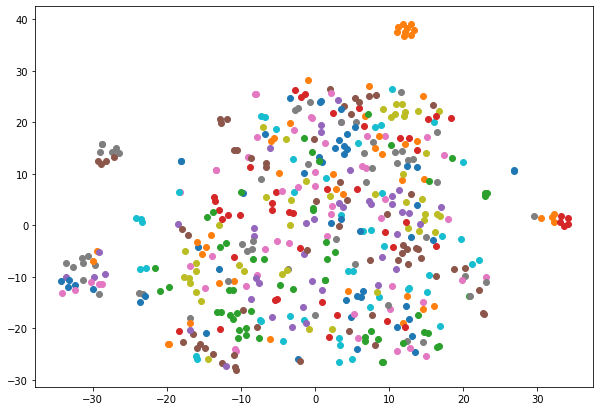

In [99]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))

classes = np.unique(sample[0]["targets"])

for c in classes:
    i = np.where(sample[0]["targets"]==c)[0]
    plt.plot(X_tnse[i,0], X_tnse[i,1], 'o')

#### Consistency and relevance

For a given random video, we check **if the nearest videos are similar**

In [101]:
nn = NearestNeighbors()
nn.fit(X)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

we choose a random video:

videos/v_Lunges_g09_c01.avi


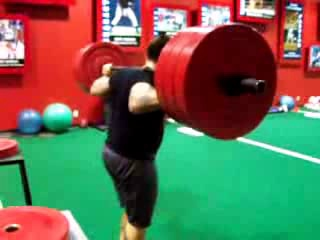

In [108]:
from IPython.display import Image

v = np.random.choice(len(sample[0]["videos"]), 1)[0]
video_name = np.array(sample[0]["videos"])[v][0].decode("utf-8")

img = train[train.videos==video_name].frames.iloc[0][0]

print(video_name)
Image(img)

we compute the neighbors: 

In [109]:
neighbors = nn.kneighbors([X[v]])[1][0][1:]

we display the nearest video:

videos/v_CleanAndJerk_g09_c02.avi


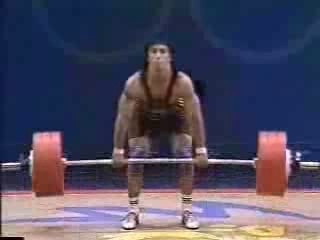

In [110]:
neigh1 = np.array(sample[0]["videos"])[neighbors[0]][0].decode("utf-8")

print(neigh1)
img = train[train.videos==neigh1].frames.iloc[0][0]
Image(img)

we check the categories of the top-4 nearest videos:

In [105]:
for i in neighbors:
    print(np.array(sample[0]["videos"])[i][0].decode("utf-8"))

videos/v_TrampolineJumping_g23_c03.avi
videos/v_PoleVault_g17_c04.avi
videos/v_Basketball_g25_c03.avi
videos/v_HighJump_g22_c01.avi


**we compute top1 & top2 accuracy**

In [130]:
a1 = 0
a2 = 0
n = len(sample[0]["videos"])

for v in range(len(sample[0]["videos"])):
    
    video_name = np.array(sample[0]["videos"])[v][0].decode("utf-8")
    category = train[train.videos==video_name].targets.iloc[0]
    
    neighbors = nn.kneighbors([X[v]])[1][0][1:] 
    
    neigh1 = np.array(sample[0]["videos"])[neighbors[0]][0].decode("utf-8")
    neigh2 = np.array(sample[0]["videos"])[neighbors[1]][0].decode("utf-8")
    
    category1 = train[train.videos==neigh1].targets.iloc[0]
    category2 = train[train.videos==neigh2].targets.iloc[0]

    if category==category1:
        a1+=1/n
    if category==category1 or category==category2:
        a2+=1/n

In [107]:
print("top1-accuracy", a1)
print("top2-accuracy", a2)

top1-accuracy 0.3900000000000003
top2-accuracy 0.5040000000000003


# 4. Supervised learning: video classification

The purpose of this section is to **automatically classify** videos. We will try (only) 2 different approaches: **average pooling** & **LSTM**. There exists a lot of different RNN architectures, which can be easily tested by adapting the following code...  

#### we read the TF records

In [261]:
batch_size = 32

train_sample = read_seqtfrecords("preprocess/train", batch_size)
test_sample = read_seqtfrecords("preprocess/test", batch_size)

timesteps = train_sample[1]["embeddings"].shape[1]
n_features = train_sample[1]["embeddings"].shape[2]
n_classes = train_sample[0]["labels"].shape[1]  # 101

n_batch = int(dataset["train"].shape[0]/batch_size)+1

## 4.a. Average pooling

We just **average** the frames features.

In [201]:
from keras.layers import AveragePooling1D, MaxPooling1D, Reshape

model compilation

In [301]:
model = Sequential()
model.add(AveragePooling1D(pool_size=timesteps, padding="valid", data_format='channels_last', input_shape=(timesteps, n_features)))
model.add(Reshape((n_features,), input_shape=(-1,1, n_features)))
model.add(Dense(n_classes, activation="softmax"))
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
average_pooling1d_30 (Averag (None, 1, 2048)           0         
_________________________________________________________________
reshape_41 (Reshape)         (None, 2048)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 101)               206949    
Total params: 206,949
Trainable params: 206,949
Non-trainable params: 0
_________________________________________________________________


fitting the model 

In [302]:
epochs = 5

model.fit(x=train_sample[1]["embeddings"], 
          y=train_sample[0]["labels"], 
          validation_data = (test_sample[1]["embeddings"], test_sample[0]["labels"]), 
          steps_per_epoch=n_batch, 
          validation_steps=10, 
          epochs=epochs)

Train on 32 samples, validate on 32 samples
Epoch 1/5
299/299 [==============================] - 1s 3ms/step - loss: 0.1098 - accuracy: 0.9842 - val_loss: 0.7750 - val_accuracy: 0.6250
Epoch 2/5
299/299 [==============================] - 1s 3ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.7661 - val_accuracy: 0.6250
Epoch 3/5
299/299 [==============================] - 1s 3ms/step - loss: 5.9379e-04 - accuracy: 1.0000 - val_loss: 0.7622 - val_accuracy: 0.6250
Epoch 4/5
299/299 [==============================] - 1s 3ms/step - loss: 3.4709e-04 - accuracy: 1.0000 - val_loss: 0.7602 - val_accuracy: 0.6250
Epoch 5/5
299/299 [==============================] - 1s 3ms/step - loss: 2.2854e-04 - accuracy: 1.0000 - val_loss: 0.7591 - val_accuracy: 0.6250


model evaluation

In [303]:
model.evaluate(x=test_sample[1]["embeddings"],
               y=test_sample[0]["labels"],
               steps=10)

10/10 [==============================] - 0s 2ms/step


[0.7591447353363037, 0.625]

model prediction

In [304]:
model.predict(x=test_sample[1]["embeddings"], 
              steps=1)

array([[1.0474200e-04, 4.5282410e-05, 1.3174910e-04, ..., 4.4840467e-04,
        3.0318614e-02, 4.0592875e-02],
       [1.1887464e-09, 3.3409794e-10, 1.0853165e-08, ..., 1.2279800e-08,
        8.9568248e-06, 2.1337294e-04],
       [1.5364436e-03, 6.2981714e-04, 1.3682182e-03, ..., 2.7031749e-03,
        7.7424389e-03, 2.5303446e-02],
       ...,
       [1.1233615e-07, 1.0820972e-08, 1.5199443e-07, ..., 3.3672430e-07,
        1.3169524e-03, 5.3502250e-02],
       [7.0186348e-07, 4.1791701e-08, 7.8081462e-07, ..., 2.5373272e-06,
        1.9932428e-02, 1.9953288e-01],
       [3.6504818e-05, 1.1524958e-05, 5.6966968e-05, ..., 1.1162461e-04,
        9.2308326e-03, 1.9433379e-01]], dtype=float32)

## 4.b. RNN : LSTM 

We try LSTM Recurrent Neural Network. 

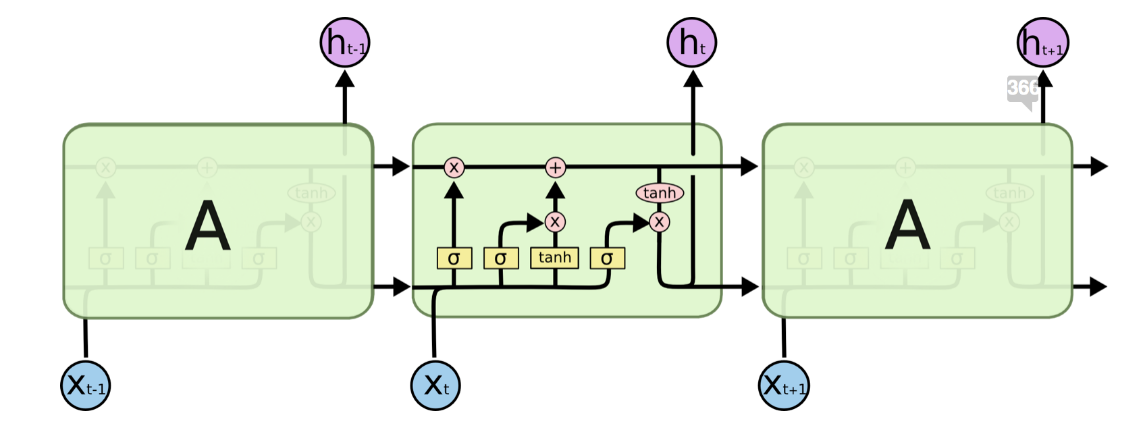

In [3]:
Image("pictures/lstm.png")

model compilation

In [305]:
dim = 1000  # can be fine-tuned...

model = Sequential()
model.add(Masking(mask_value=0., input_shape=(timesteps, n_features)))
model.add(LSTM(dim, activation='relu'))
#model.add(LSTM(dim, activation='relu', input_shape=(timesteps, n_features)))
model.add(Dense(n_classes, activation="softmax"))
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_12 (Masking)         (None, 10, 2048)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 1000)              12196000  
_________________________________________________________________
dense_43 (Dense)             (None, 101)               101101    
Total params: 12,297,101
Trainable params: 12,297,101
Non-trainable params: 0
_________________________________________________________________


fitting the model

**[DO NOT RUN LOCALLY]**

In [306]:
epochs = 3

model.fit(x=train_sample[1]["embeddings"], 
          y=train_sample[0]["labels"], 
          validation_data = (test_sample[1]["embeddings"], test_sample[0]["labels"]), 
          steps_per_epoch=n_batch, 
          validation_steps=5, 
          epochs=epochs)

Train on 32 samples, validate on 32 samples
Epoch 1/3
299/299 [==============================] - 131s 439ms/step - loss: 0.2276 - accuracy: 0.9868 - val_loss: 4.3961 - val_accuracy: 0.1562
Epoch 2/3
299/299 [==============================] - 125s 417ms/step - loss: 4.3705e-07 - accuracy: 1.0000 - val_loss: 4.4425 - val_accuracy: 0.1562
Epoch 3/3
299/299 [==============================] - 124s 416ms/step - loss: 2.0808e-07 - accuracy: 1.0000 - val_loss: 4.4740 - val_accuracy: 0.1562


In [ ]:
# model.save_weights('lstm.h5')

model evaluation

In [ ]:
# model.load_weights('lstm.h5')

In [307]:
model.evaluate(x=test_sample[1]["embeddings"],
               y=test_sample[0]["labels"],
               steps=10)

10/10 [==============================] - 1s 125ms/step


[2.237022590637207, 0.3125]

model prediction

In [308]:
model.predict(x=test_sample[1]["embeddings"], 
              steps=1)

array([[1.1339869e-11, 3.6703131e-08, 1.8983866e-07, ..., 1.1310962e-08,
        9.5616281e-03, 1.5559676e-03],
       [2.7281254e-31, 7.2505983e-33, 9.4237475e-20, ..., 7.9829739e-23,
        5.4221760e-15, 9.7166158e-14],
       [1.4936405e-06, 3.3773185e-04, 3.2339711e-04, ..., 4.0147098e-04,
        5.9412131e-03, 1.9327349e-03],
       ...,
       [2.6597331e-30, 6.1303987e-29, 7.6284284e-18, ..., 3.9117211e-19,
        3.5272241e-12, 2.2665516e-09],
       [4.9624030e-30, 3.6364762e-30, 6.5090007e-18, ..., 1.9247975e-19,
        3.7590913e-13, 5.7513283e-08],
       [2.0827749e-12, 4.4789367e-11, 3.5669856e-07, ..., 1.0292791e-06,
        1.0410044e-03, 1.6293384e-02]], dtype=float32)

# 5. Introduction to multi-modal classification models

This section is an **introduction** on multi-modal classification models. We will just give some insights. 

## 5.a. Definition

A multi-modal model takes as inputs **several different types of data (or modes)**, eg: 

- images
- text
- sound
- dates
- ...

This is the case if you consider that a video is not only characterized by the **frames** but also by its **description/title**. 

## 5.b. Modes aggregation/combination/fusion

**IMPORTANT:** this is important to keep in mind that each mode can output relatively **different** information and all of them can be **correct**. 

*Eg: a video which frames are showing the Arctic sea ice and the text about  global warming and greenhouse gazes...*

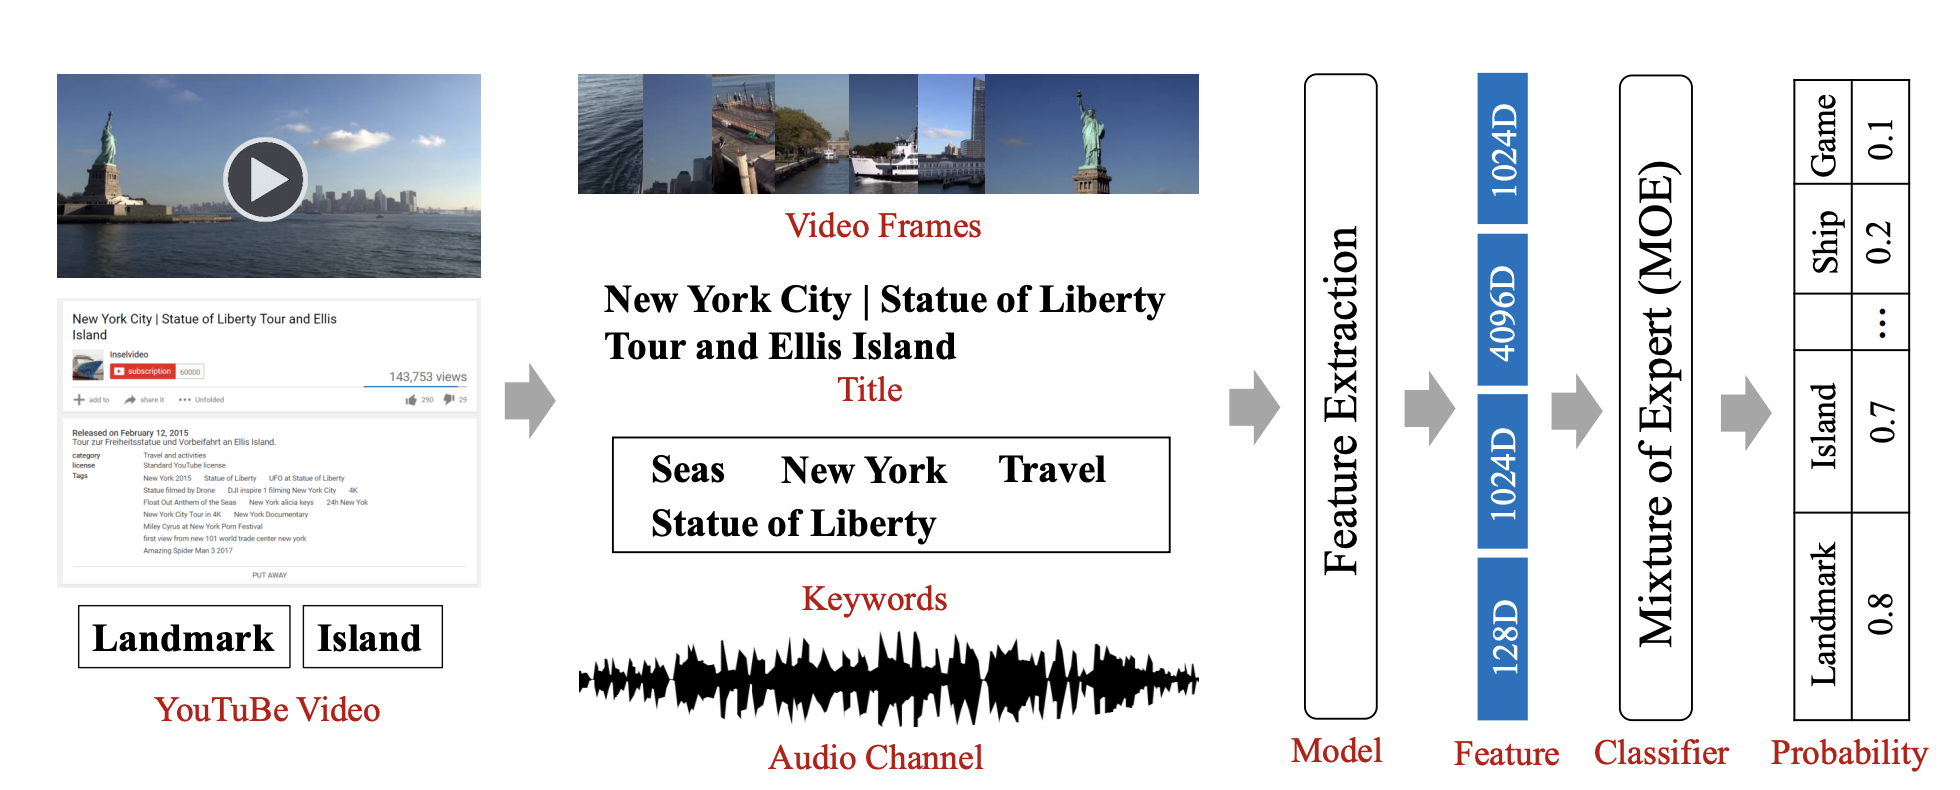

In [309]:
Image("pictures/multimodal.png")

Thus, the issue is to **efficiently combine the different information**. Among all the possibilities to combine different sources of information, we can list the following ones :

#### i) Features concatenation

This can be used if all the sources are represented as a multi-dimensional embedding. 

*E.g: video is encoded in a 2048-dimensional vector like in the previous sections and the description is embedded using SOTA NLP algorithms like BERT...*

The idea is just to **concatenate the embeddings**

#### ii) Embedding alignment

Same hypothesis. 

But the idea is a little more complex: instead of concatenation, we **learn a joint embedding** that takes into account the correlations between all the embeddings. Also, it allows to reduce the dimensionality. 

#### iii) Prediction combination/fusion: MoE (Mixture of Experts) 

Here, we suppose that **each mode outputs several categories** (and its probabilities). 

We would like to build an accurate multi-label classification model on the top of it that allows us to **pick the appropriate categories among all the predicted categories.** 

The idea is to get a training set for the fusion and fit a classification model. 

# Conclusion

What has been seen so far ? 

- how to **encode** videos using CNN & RNN.
- how to **classify** videos using CNN & RNN.
- introduction to **multi-modal** model.

# References

- https://machinelearningmastery.com/lstm-autoencoders/
- https://arxiv.org/abs/1502.04681

# Code available here: 

**https://github.com/AxeldeRomblay/**  

# धन्यवाद